# 0) Import des Librairies

---



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import seaborn as sns
import plotly.figure_factory as ff

import numpy as np

In [3]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

C:\Users\edmee\AppData\Local\Temp\ipykernel_19744\4139613647.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',30)

In [13]:
df=pd.read_csv('./Data/station_paris.csv')

### Visualisation des observations de hauteur par date

In [15]:
df['date_obs_elab'] = pd.to_datetime(df['date_obs_elab'])

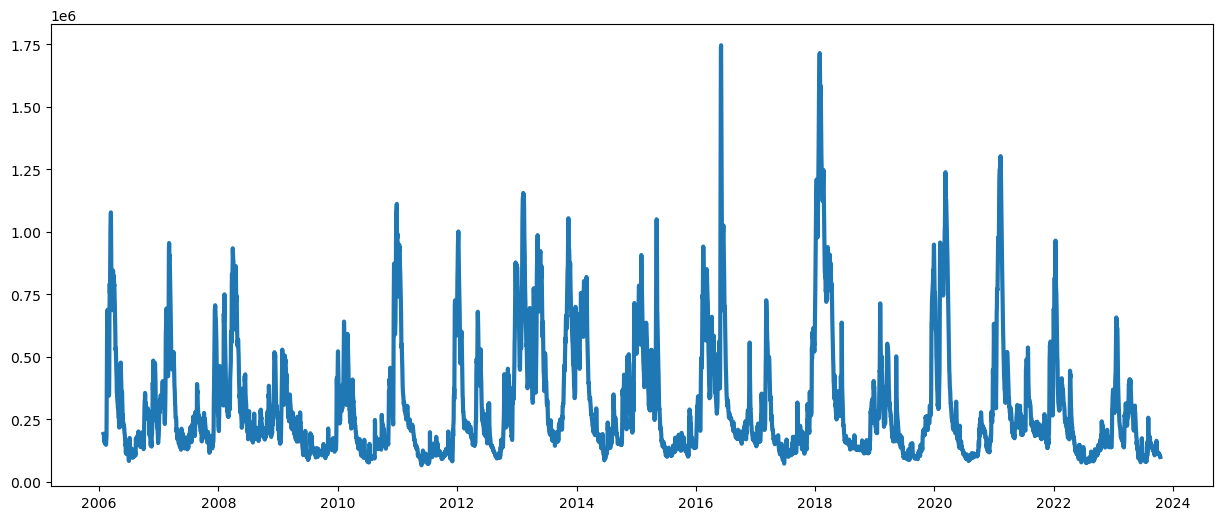

In [16]:
plt.figure(figsize=(15, 6))
plt.plot(df["date_obs_elab"], df["resultat_obs_elab"], linewidth=3)

In [17]:
fig = px.histogram(df, x="resultat_obs_elab")
fig.show()

In [18]:

fig = px.box(df, y="resultat_obs_elab")

fig.show(renderer="colab")

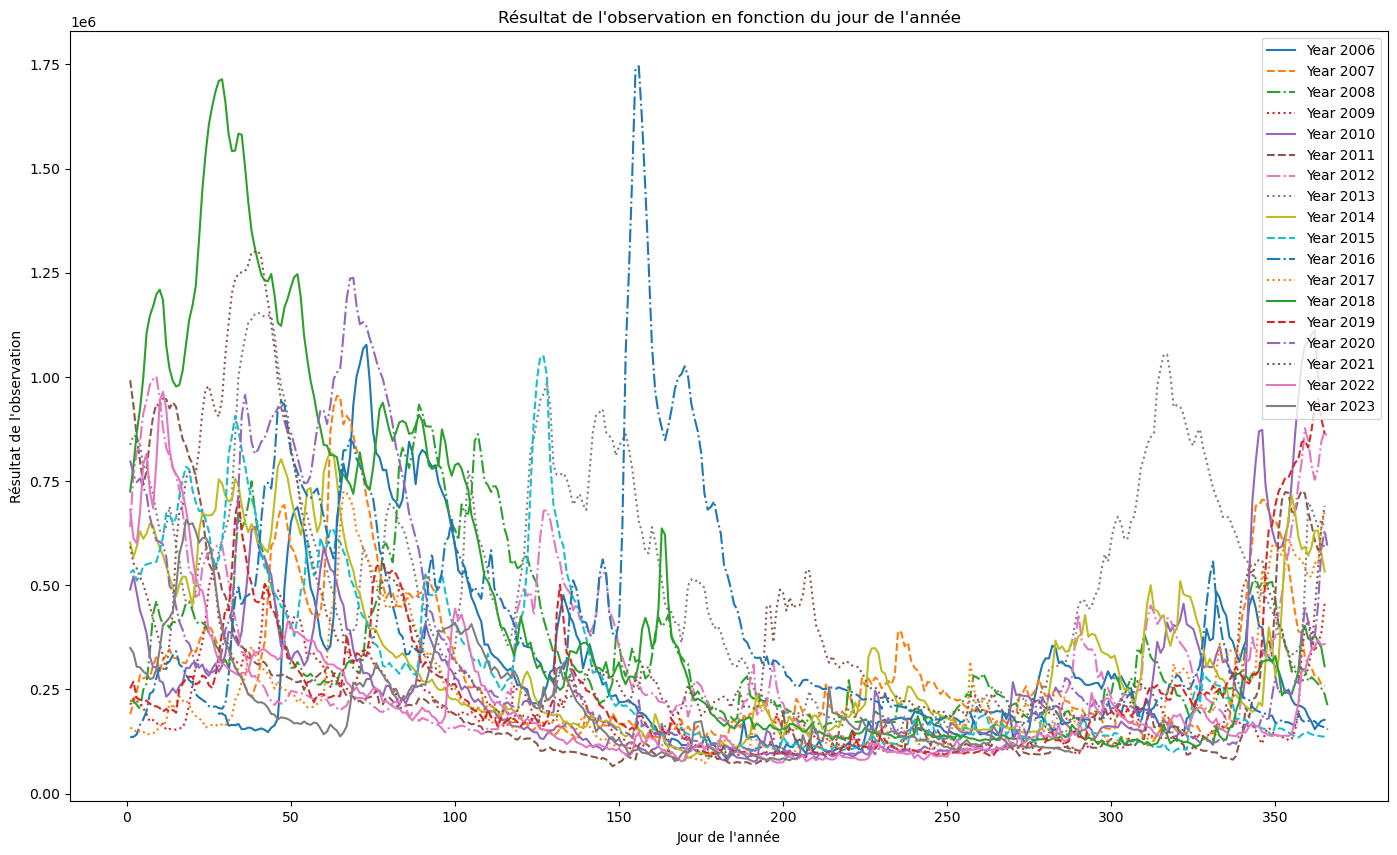

In [19]:
df['year'] = df['date_obs_elab'].dt.year

plt.figure(figsize=(17, 10))

# Définir les styles de ligne disponibles
styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']

for i, (year, group) in enumerate(df.groupby('year')):
    day_of_year = group['date_obs_elab'].dt.dayofyear
    plt.plot(day_of_year, group['resultat_obs_elab'], label=f'Year {year}', linestyle=styles[i % len(styles)])

plt.xlabel('Jour de l\'année')
plt.ylabel('Résultat de l\'observation')
plt.title('Résultat de l\'observation en fonction du jour de l\'année')
plt.legend(loc='upper right')

plt.show()

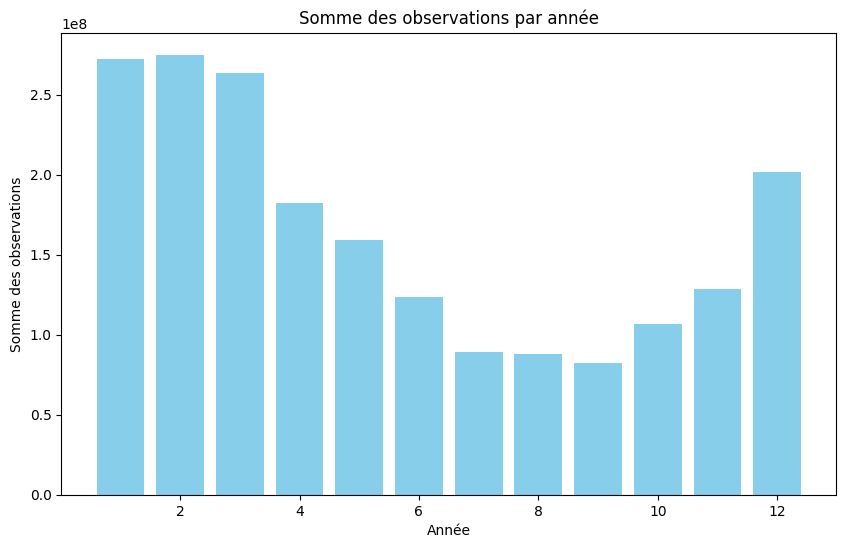

In [ ]:
df['month'] = df['date_obs_elab'].dt.month

summed_data = df.groupby('month')['resultat_obs_elab'].sum()

plt.figure(figsize=(10, 6))

plt.bar(summed_data.index, summed_data.values, color='skyblue')
plt.xlabel('Année')
plt.ylabel('Somme des observations')
plt.title('Somme des observations par année')
plt.show()

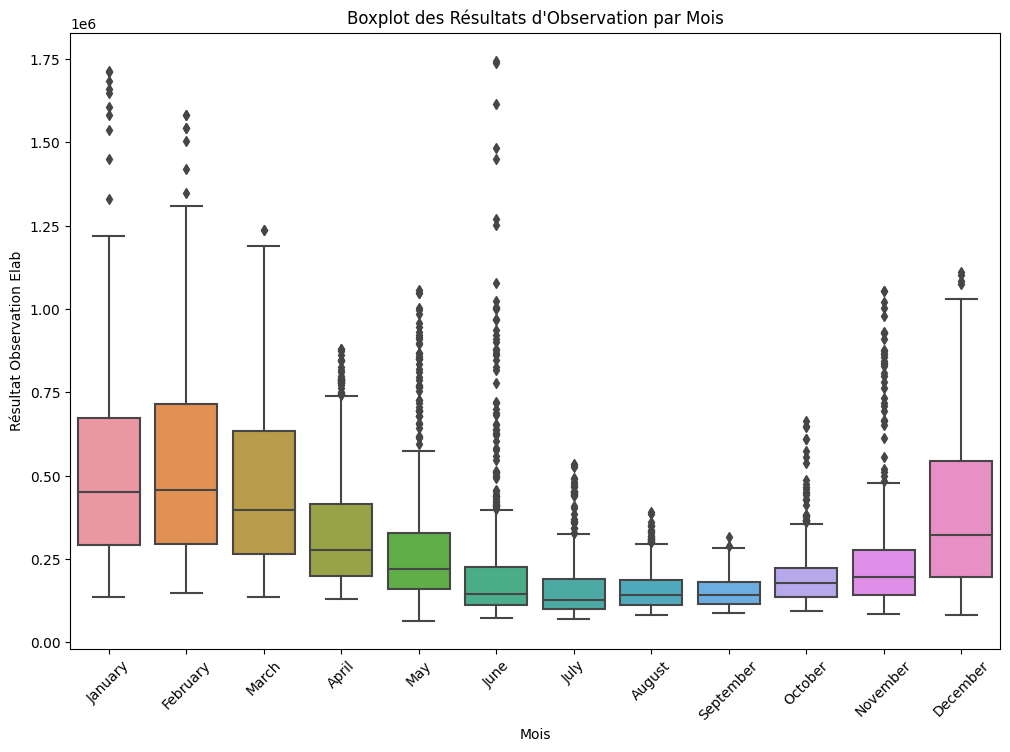

In [ ]:
df['Mois'] = df['date_obs_elab'].dt.month_name()

plt.figure(figsize=(12, 8))
sns.boxplot(x='Mois', y='resultat_obs_elab', data=df)

plt.xlabel('Mois')
plt.ylabel('Résultat Observation Elab')
plt.title('Boxplot des Résultats d\'Observation par Mois')

plt.xticks(rotation=45)
plt.show()


In [ ]:
a=df.groupby(["month"]).max()["resultat_obs_elab"]

<Axes: xlabel='month'>

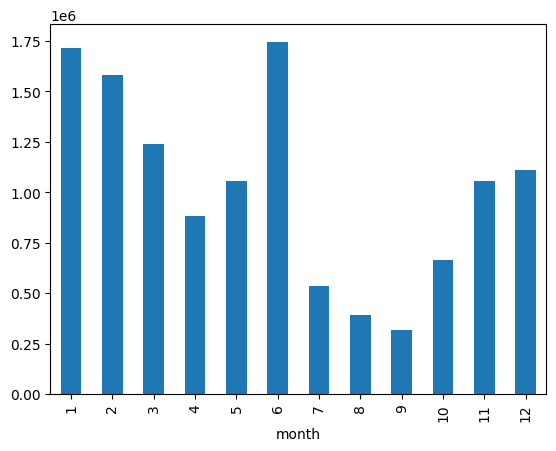

In [ ]:
a.plot(kind='bar')

# 4) Modélisation time series exemple :

In [ ]:
df['date_obs_elab'] = pd.to_datetime(df['date_obs_elab'])

In [ ]:
ts = df[(df['date_obs_elab'].dt.year <2023)]

In [ ]:
ts=ts[["date_obs_elab", "resultat_obs_elab"]]

## Exploration des tendances et saisonnalités

<Figure size 5600x2600 with 0 Axes>

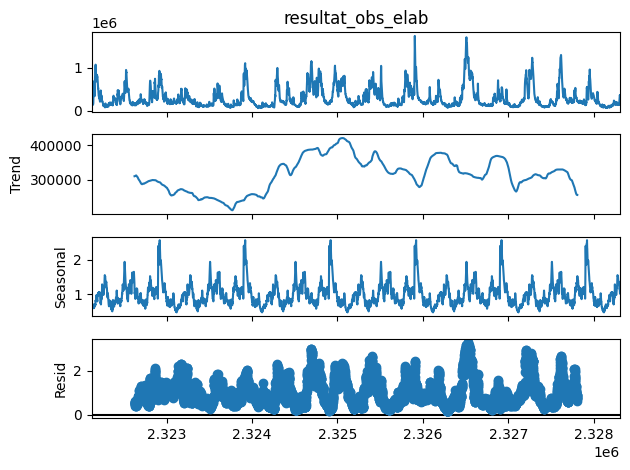

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(56, 26))

result = seasonal_decompose(ts['resultat_obs_elab'], model='multiplicative', period=1000)

result.plot()
plt.show()

<Figure size 4600x1600 with 0 Axes>

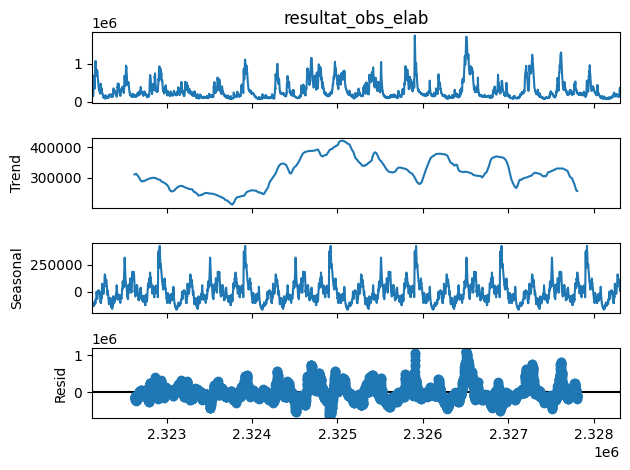

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(46, 16))

result = seasonal_decompose(ts['resultat_obs_elab'], model='additive', period=1000)

result.plot()
plt.show()


Pas l'air d'avoir de tendances, mais peut etre saisonalié

## Exploration de la saisonalité

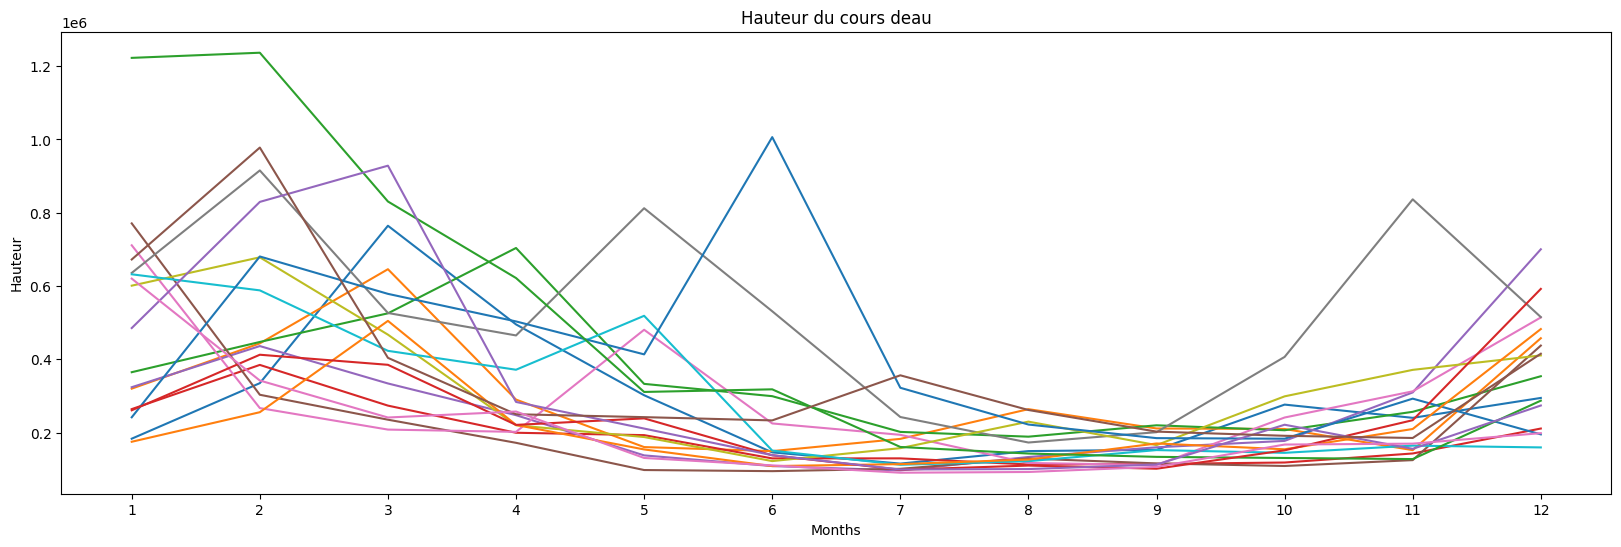

In [ ]:
ts['month'] = ts['date_obs_elab'].dt.month
ts['year'] = ts['date_obs_elab'].dt.year
pivot = pd.pivot_table(ts, values='resultat_obs_elab', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Hauteur du cours deau')
plt.xlabel('Months')
plt.ylabel('Hauteur')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

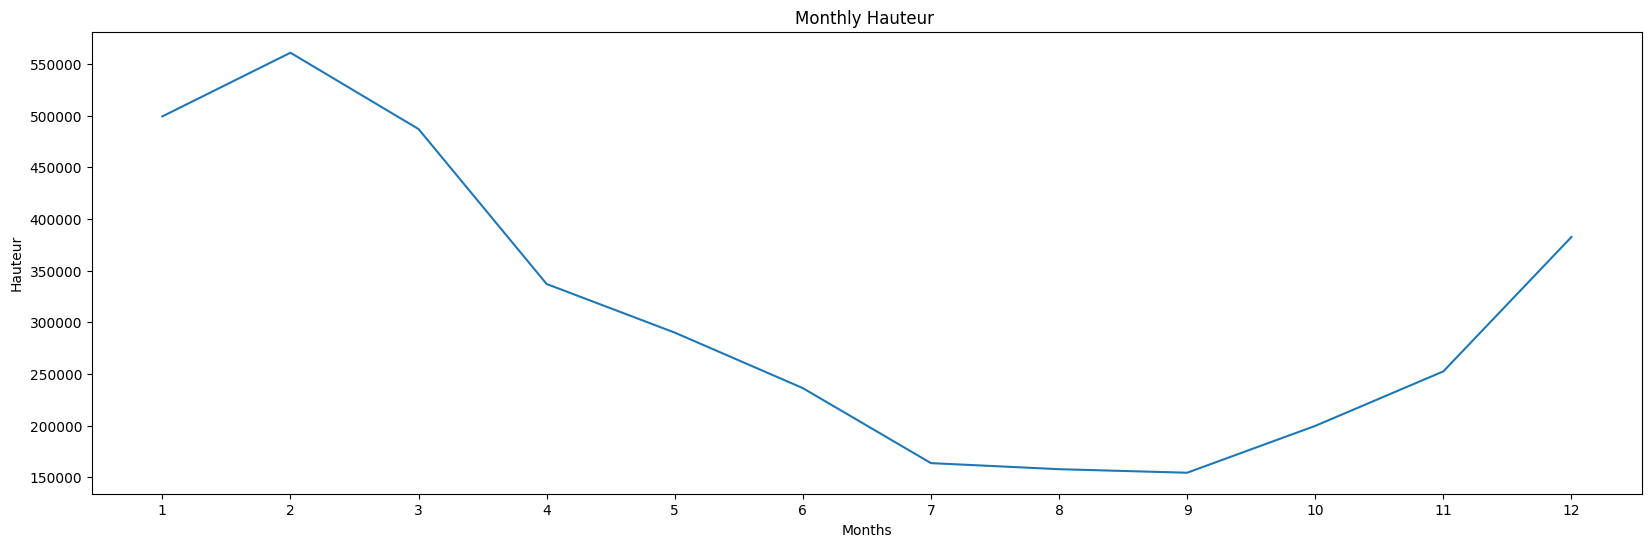

In [ ]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Monthly Hauteur ')
plt.xlabel('Months')
plt.ylabel('Hauteur')
plt.xticks([x for x in range(1,13)])
plt.show()

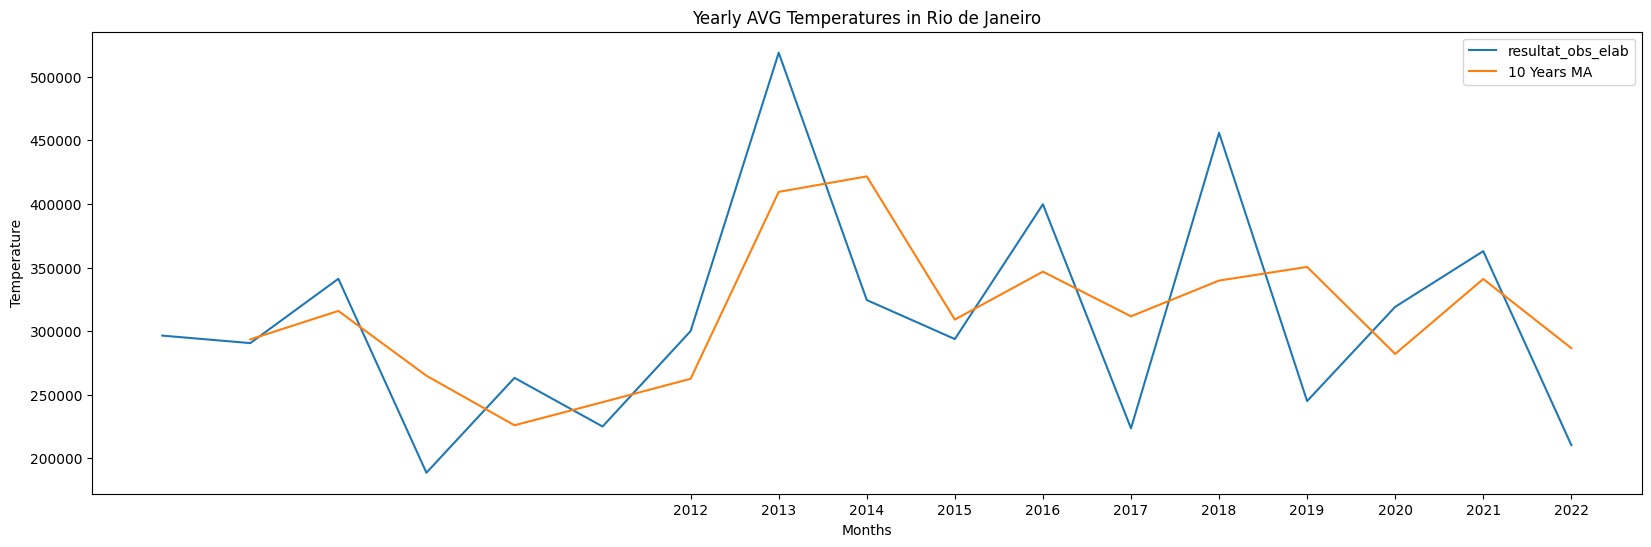

In [ ]:
year_avg = pd.pivot_table(ts, values='resultat_obs_elab', index='year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['resultat_obs_elab'].rolling(2).mean()
year_avg[['resultat_obs_elab','10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly AVG Hauteur deau')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(2012,2023)])
plt.show()

Pas de trend

In [ ]:
decompose_data = seasonal_decompose(ts['resultat_obs_elab'], model="additive", period=2000)

##Test de stationnarité

In [ ]:
from statsmodels.tsa.stattools import adfuller

resultat_obs_elab = ts['resultat_obs_elab']
result = adfuller(resultat_obs_elab)

print('Statistique ADF :', result[0])
print('p-value :', result[1])
print('Lags utilisés :', result[2])
print('Nombre d\'observations utilisées :', result[3])
print('Valeurs critiques :', result[4])


Statistique ADF : -7.506487693804682
p-value : 4.12163444074124e-11
Lags utilisés : 11
Nombre d'observations utilisées : 6170
Valeurs critiques : {'1%': -3.431410295408432, '5%': -2.8620085554741395, '10%': -2.567019409281592}


Ainsi, la ST semble stationnaire

## Visualisation de l'autocorrélation

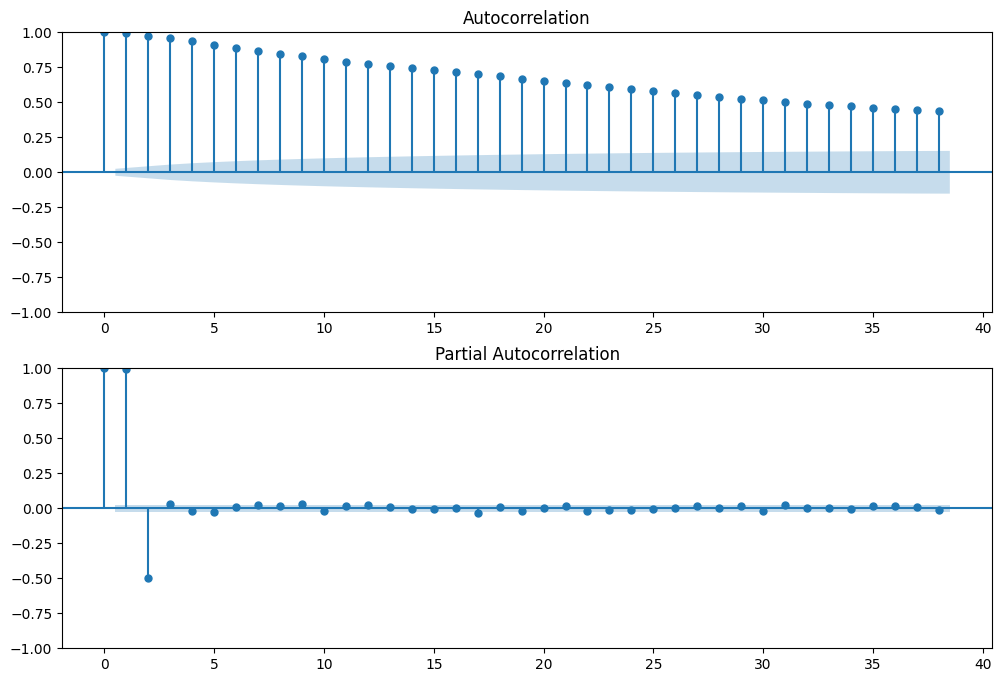

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(resultat_obs_elab, ax=ax[0])
plot_pacf(resultat_obs_elab, ax=ax[1])
plt.show()


#Modélisation

In [ ]:
timeSeries = df.loc[:, ["date_obs_elab","resultat_obs_elab"]]
timeSeries.index = timeSeries.date_obs_elab
ts = timeSeries.drop("date_obs_elab",axis=1)

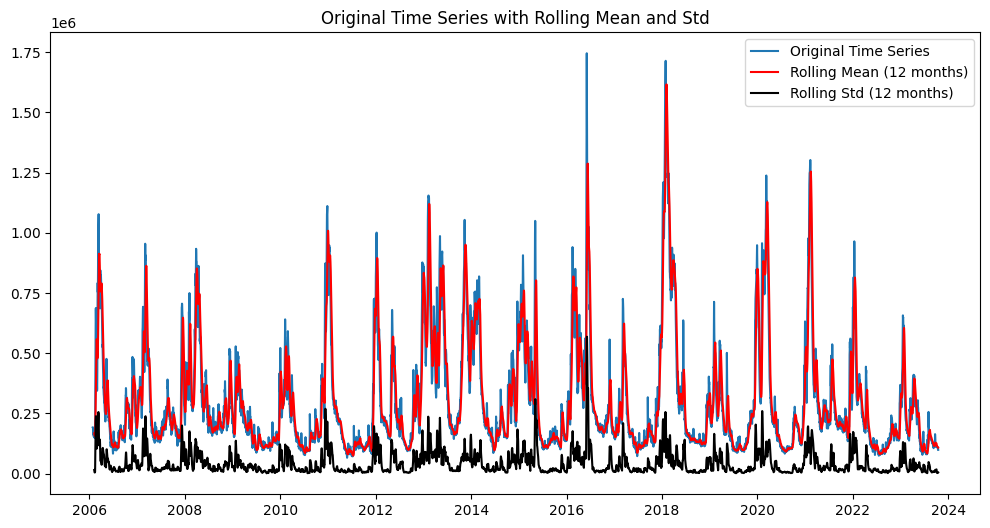

ADF Statistic: -7.647250100714842
p-value: 1.8287331404150757e-11
Critical Values: {'1%': -3.4313629918181077, '5%': -2.8619876550915135, '10%': -2.567008283518796}
Is the time series stationary? Yes


In [ ]:
def check_mean_std(ts):
    rolling_mean = ts.rolling(window=12).mean()
    rolling_std = ts.rolling(window=12).std()

    plt.figure(figsize=(12, 6))
    plt.plot(ts, label='Original Time Series')
    plt.plot(rolling_mean, label='Rolling Mean (12 months)', color='red')
    plt.plot(rolling_std, label='Rolling Std (12 months)', color='black')
    plt.legend()
    plt.title('Original Time Series with Rolling Mean and Std')
    plt.show()

def check_adfuller(ts):
    result = adfuller(ts['resultat_obs_elab'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print('Is the time series stationary? ' + ('Yes' if result[1] < 0.05 else 'No'))


check_mean_std(ts['resultat_obs_elab'])
check_adfuller(ts)

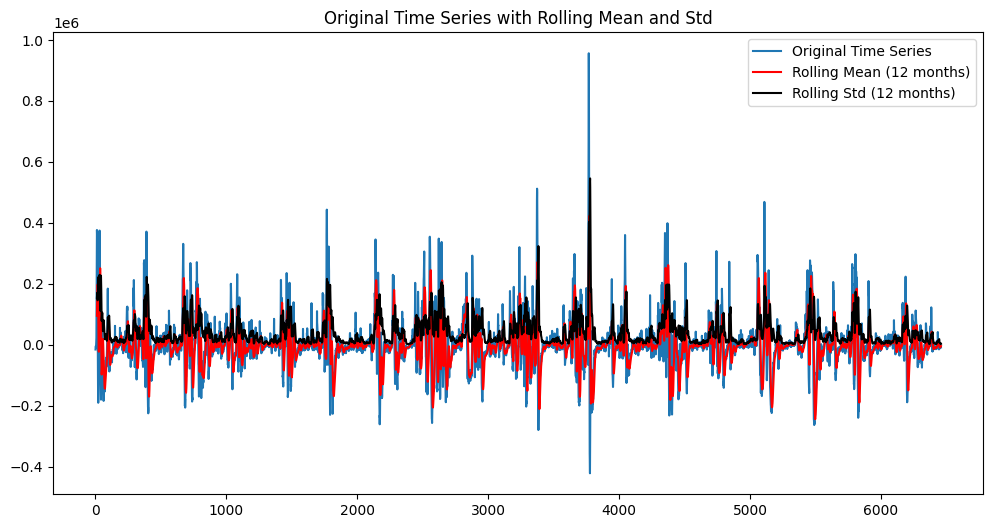

ADF Statistic: -16.046715603185156
p-value: 5.834022799122903e-29
Critical Values: {'1%': -3.431367563058534, '5%': -2.8619896748401086, '10%': -2.5670093586757545}
Is the time series stationary? Yes


In [ ]:
rolling_mean = ts['resultat_obs_elab'].rolling(window=12).mean()

#On enleve la saisonalité
ts_moving_avg_diff = ts['resultat_obs_elab'] - rolling_mean
ts_moving_avg_diff.dropna(inplace=True)  # first 12 values are nan due to window size

ts_moving_avg_diff=ts_moving_avg_diff.reset_index()
check_mean_std(ts_moving_avg_diff['resultat_obs_elab'])
check_adfuller(ts_moving_avg_diff)

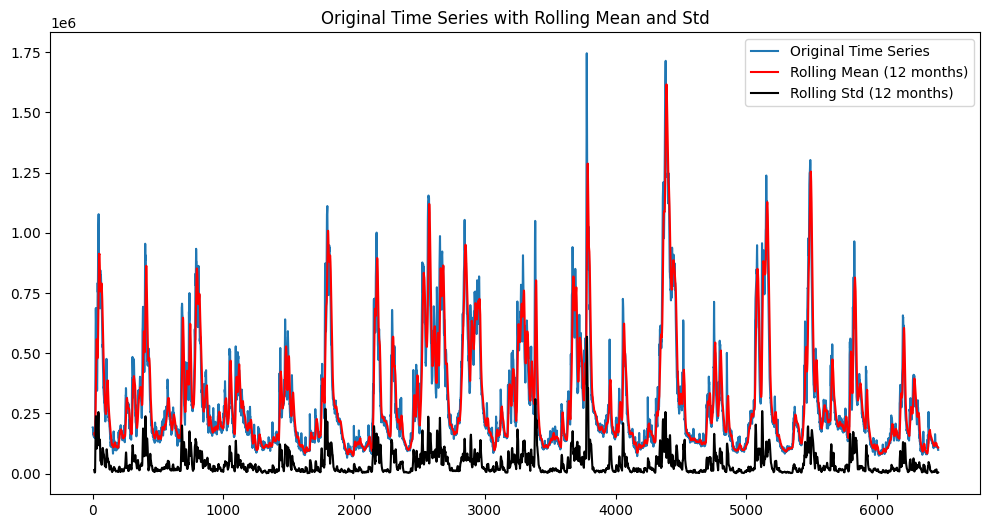

ADF Statistic: -7.647250100714842
p-value: 1.8287331404150757e-11
Critical Values: {'1%': -3.4313629918181077, '5%': -2.8619876550915135, '10%': -2.567008283518796}
Is the time series stationary? Yes


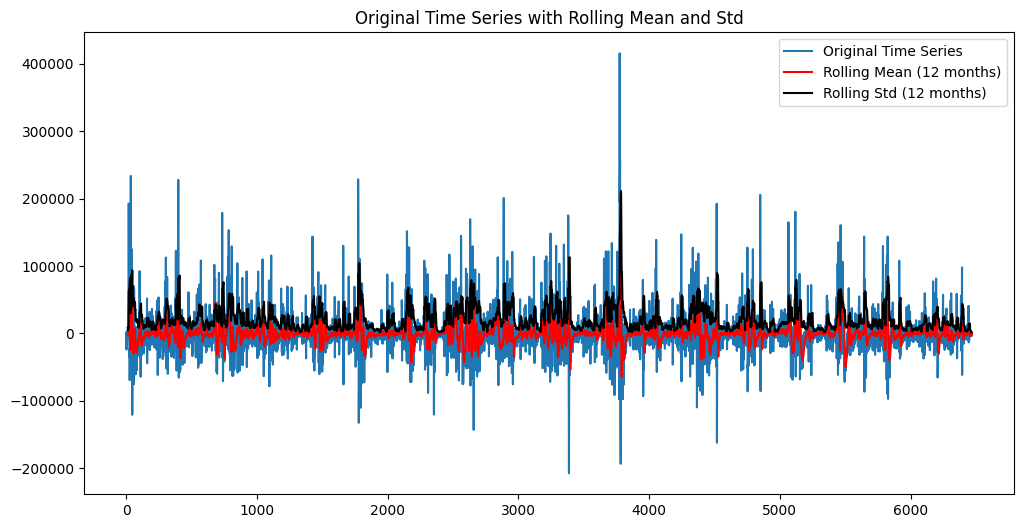

ADF Statistic: -24.91686695069564
p-value: 0.0
Critical Values: {'1%': -3.4313631487632765, '5%': -2.8619877244359344, '10%': -2.56700832043236}
Is the time series stationary? Yes


In [ ]:
# differencing method
ts_diff = ts - ts.shift()

check_mean_std(ts.reset_index()['resultat_obs_elab'])
check_adfuller(ts.reset_index())

ts_diff.dropna(inplace=True)
check_mean_std(ts_diff.reset_index()['resultat_obs_elab'])
check_adfuller(ts_diff.reset_index())

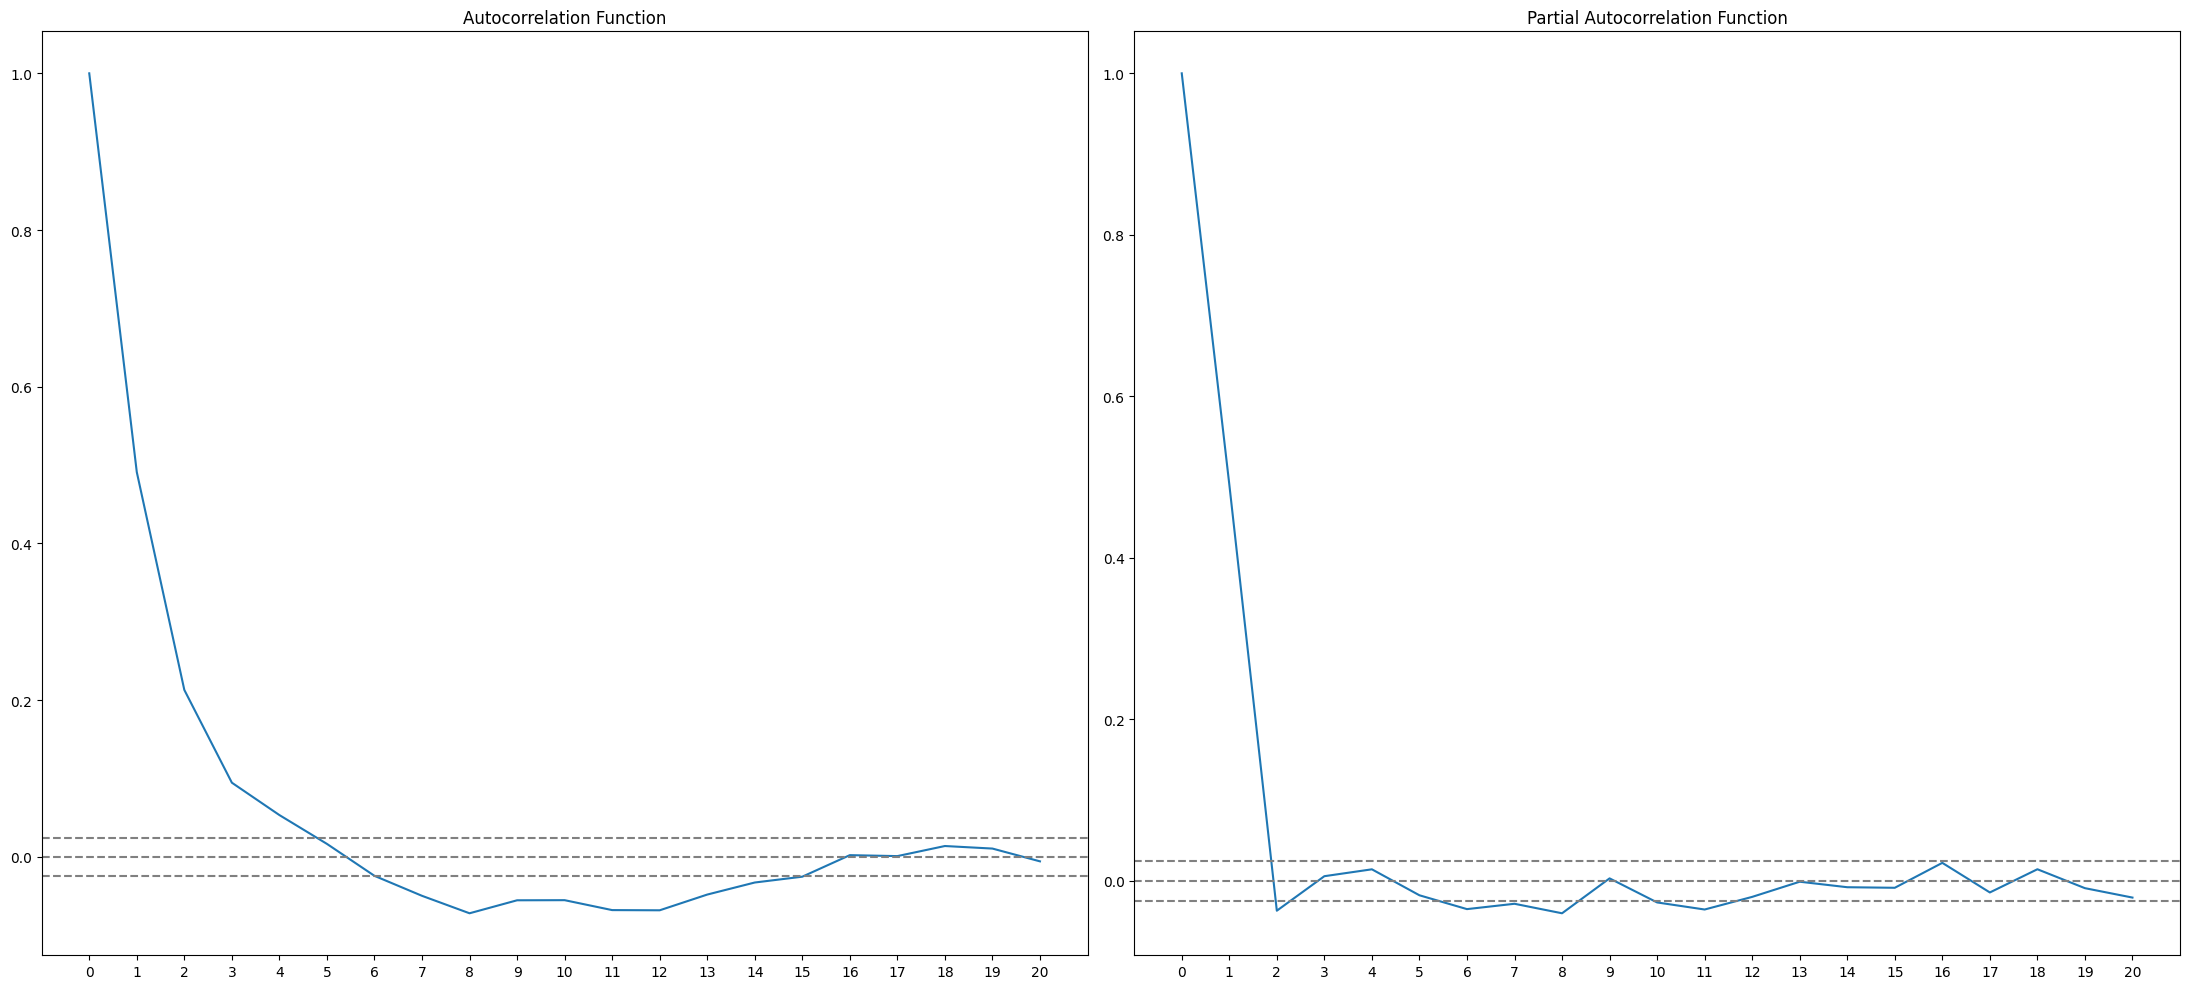

In [ ]:
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

# ACF
plt.figure(figsize=(22, 10))

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.xticks(np.arange(0, 21, 1))  # Mettez des marques sur l'axe x tous les 1

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.xticks(np.arange(0, 21, 1))  # Mettez des marques sur l'axe x tous les 1

plt.tight_layout()
plt.show()

In [ ]:
p=2
q=5

In [ ]:
train_size = int(len(ts_diff) * 0.8)
train, test = ts_diff[:train_size], ts_diff[train_size:]

In [ ]:
model = ARIMA(train, order=(2,0,5))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


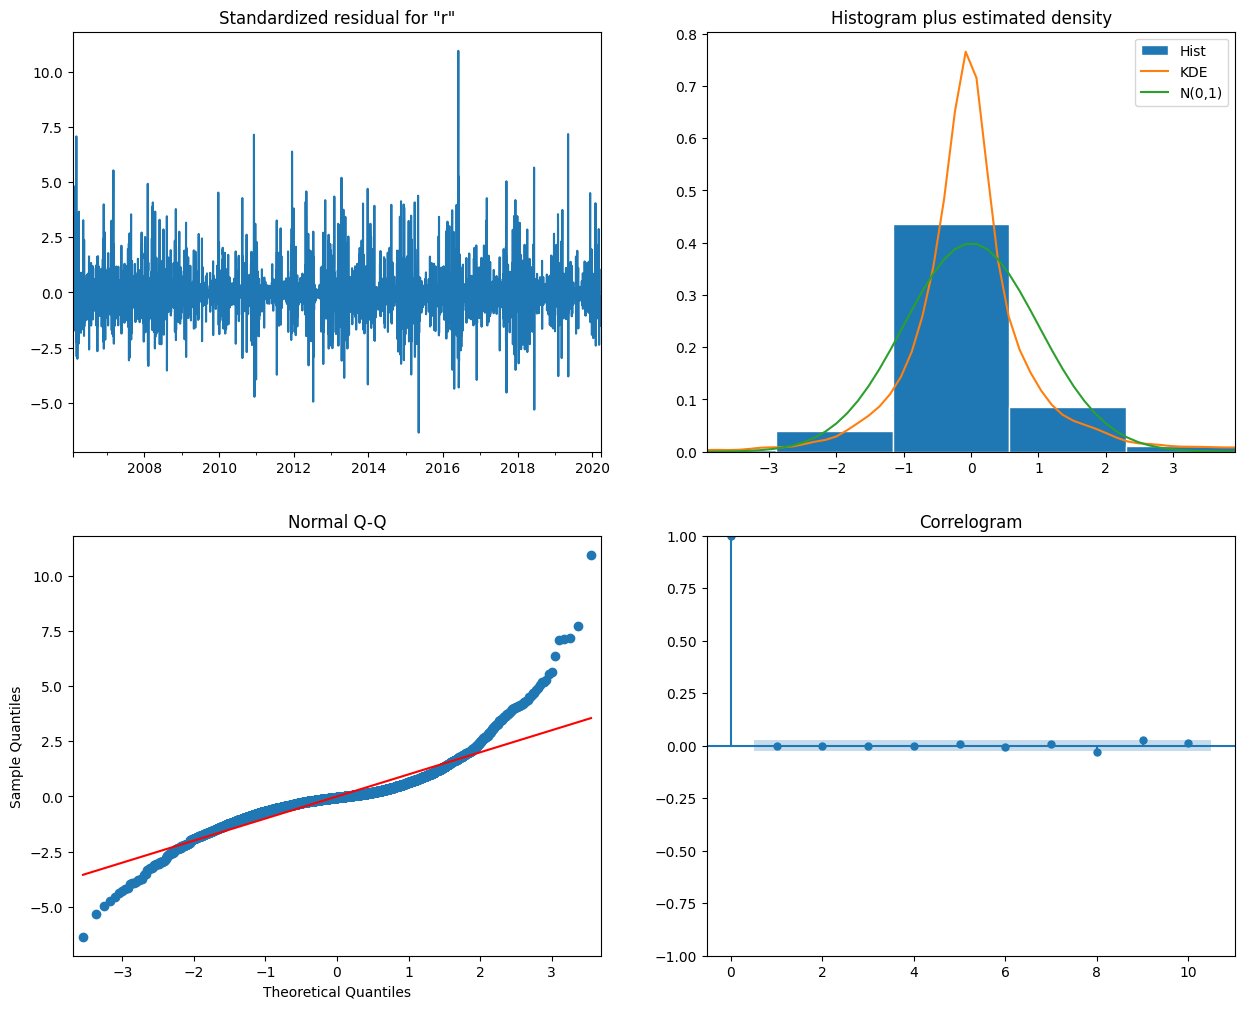

In [ ]:
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
start_index = test.reset_index()['date_obs_elab'].min()
end_index = test.reset_index()['date_obs_elab'].max()
forecast = model_fit.get_prediction(start=start_index, end=end_index,dynamic=True)
forecast_mean = forecast.predicted_mean
resulta=model_fit.predict(start=start_index, end=end_index)
confidence_interval = forecast.conf_int()

ValueError: ignored

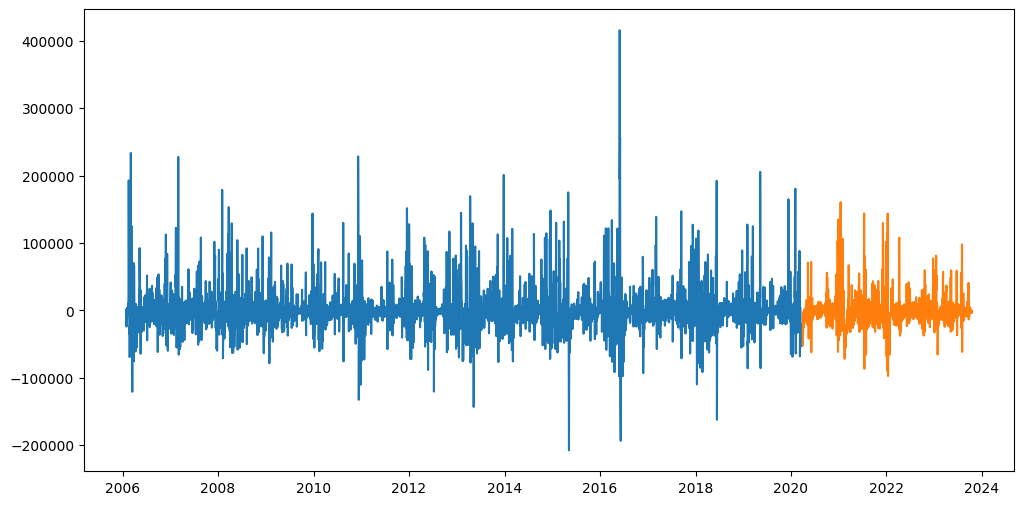

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.reset_index()['date_obs_elab'], train.reset_index()['resultat_obs_elab'], label='Train')
plt.plot(test.reset_index()['date_obs_elab'], test.reset_index()['resultat_obs_elab'], label='Test')
plt.plot(test.reset_index()['date_obs_elab'],resulta, label='Predicted', color='red')
plt.fill_between(forecast_mean.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Hauteur")
plt.legend()
plt.show()


In [ ]:
end_index

Timestamp('2023-10-15 00:00:00')

In [ ]:
start_index2=end_index
end_index2 = datetime(2024, 12, 31)

In [ ]:


forecast = model_fit.get_forecast(start_index2, end_index2,dynamic=True)
forecast_mean = forecast.predicted_mean
resulta=model_fit.predict(start=start_index2, end=end_index2)
confidence_interval = forecast.conf_int()

In [ ]:
new_index = pd.date_range(start=start_index2, end=end_index2)

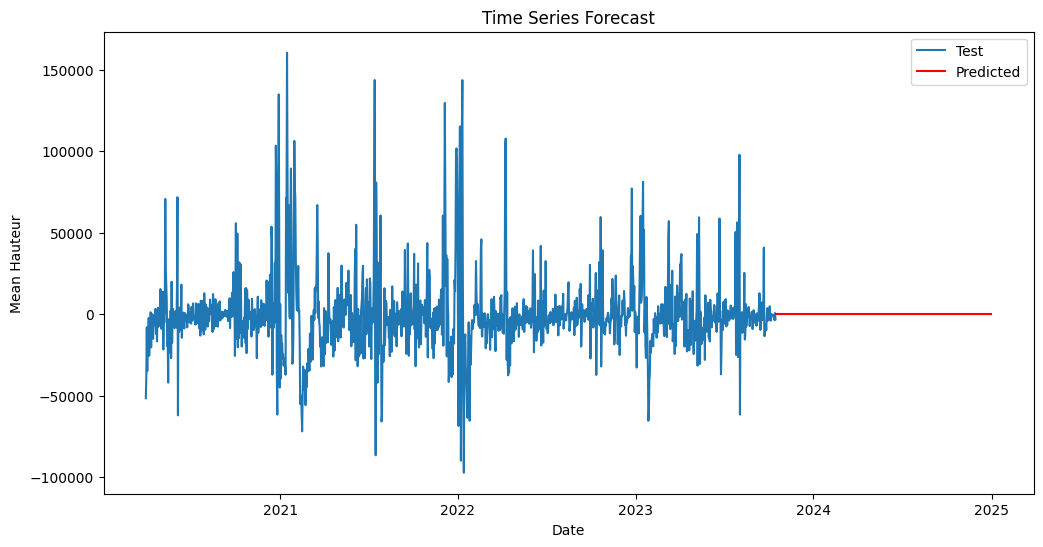

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test.reset_index()['date_obs_elab'], test.reset_index()['resultat_obs_elab'], label='Test')
plt.plot(new_index,resulta, label='Predicted', color='red')
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Hauteur")
plt.legend()
plt.show()


# Modélisation Loi Binomiale (proba dépassé le seuil)

In [ ]:
station1.head()

,code_site,code_station,date_obs_elab,resultat_obs_elab,grandeur_hydro_elab,longitude_station,latitude_station,altitude_ref_alti_station,libelle_site,libelle_station,code_cours_eau,libelle_cours_eau,longitude_site,altitude_site,Annee_hauteur,depasse
0,10150001,1015000101,2005-02-22,2106.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,1
1,10150001,1015000101,2005-02-23,973.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,0
2,10150001,1015000101,2005-02-24,2758.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,1
3,10150001,1015000101,2005-02-25,2818.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,1
4,10150001,1015000101,2005-02-26,2521.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,1


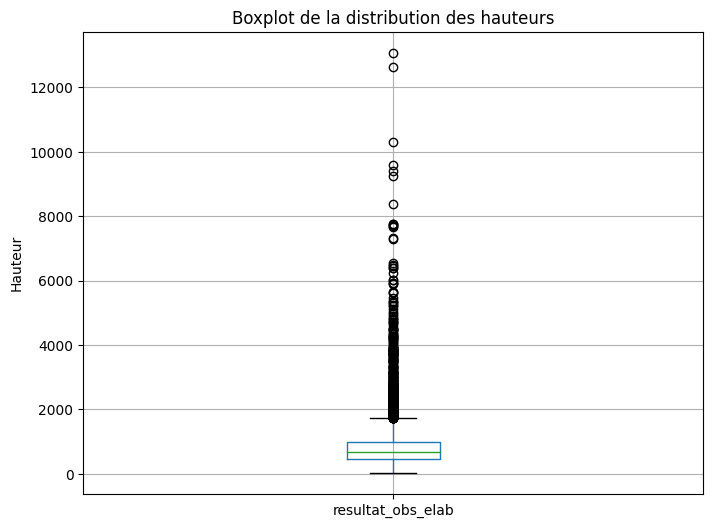

In [ ]:
plt.figure(figsize=(8, 6))
station1.boxplot(column='resultat_obs_elab')
plt.title('Boxplot de la distribution des hauteurs')
plt.ylabel('Hauteur')
plt.show()

In [ ]:
 moyenne = station1.resultat_obs_elab.quantile(0.5)
 moyenne

665.0

 On observe une hauteur moyenne de 665

In [ ]:
station1["Annee_hauteur"] = station1["date_obs_elab"].dt.year
station1["Mois_hauteur"] = station1["date_obs_elab"].dt.month
station1["Jour_hauteur"] = station1["date_obs_elab"].dt.day
station1.head(1)

,code_site,code_station,date_obs_elab,resultat_obs_elab,grandeur_hydro_elab,longitude_station,latitude_station,altitude_ref_alti_station,libelle_site,libelle_station,code_cours_eau,libelle_cours_eau,longitude_site,altitude_site,Annee_hauteur,depasse,Mois_hauteur,Jour_hauteur
0,10150001,1015000101,2005-02-22,2106.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,1,2,22


In [ ]:
fig = px.histogram(station1, x="Annee_hauteur")
fig.show()

 très peu informations en 2012 tentative premier modèle sur la période 20213-2016 voir sans utilisé valeur hauteur en X

In [ ]:

seuil = station1.resultat_obs_elab.quantile(0.75)


station1['depasse'] = (station1['resultat_obs_elab'] > seuil).astype(int)




In [ ]:
station1

,code_site,code_station,date_obs_elab,resultat_obs_elab,grandeur_hydro_elab,longitude_station,latitude_station,altitude_ref_alti_station,libelle_site,libelle_station,code_cours_eau,libelle_cours_eau,longitude_site,altitude_site,Annee_hauteur,depasse,Mois_hauteur,Jour_hauteur,ratio
0,10150001,1015000101,2005-02-22,2106.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,1,2,22,0.000000
1,10150001,1015000101,2005-02-23,973.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,0,2,23,0.462013
2,10150001,1015000101,2005-02-24,2758.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,1,2,24,2.834532
3,10150001,1015000101,2005-02-25,2818.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,1,2,25,1.021755
4,10150001,1015000101,2005-02-26,2521.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,1,2,26,0.894606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3784,10150001,1015000101,2016-12-18,628.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2016,0,12,18,0.981250
3785,10150001,1015000101,2016-12-19,1397.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2016,1,12,19,2.224522
3786,10150001,1015000101,2016-12-20,906.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2016,0,12,20,0.648533
3787,10150001,1015000101,2016-12-21,1101.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2016,1,12,21,1.215232


In [ ]:
 seuil1 = station1.resultat_obs_elab.quantile(0.75)
 seuil1

977.0

In [ ]:
station1['depasse'] = (station1['resultat_obs_elab'] > seuil1).astype(int)

In [ ]:
X = station1[['resultat_obs_elab','Annee_hauteur']]
y = station1['depasse']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
predictions = model.predict(X_test)

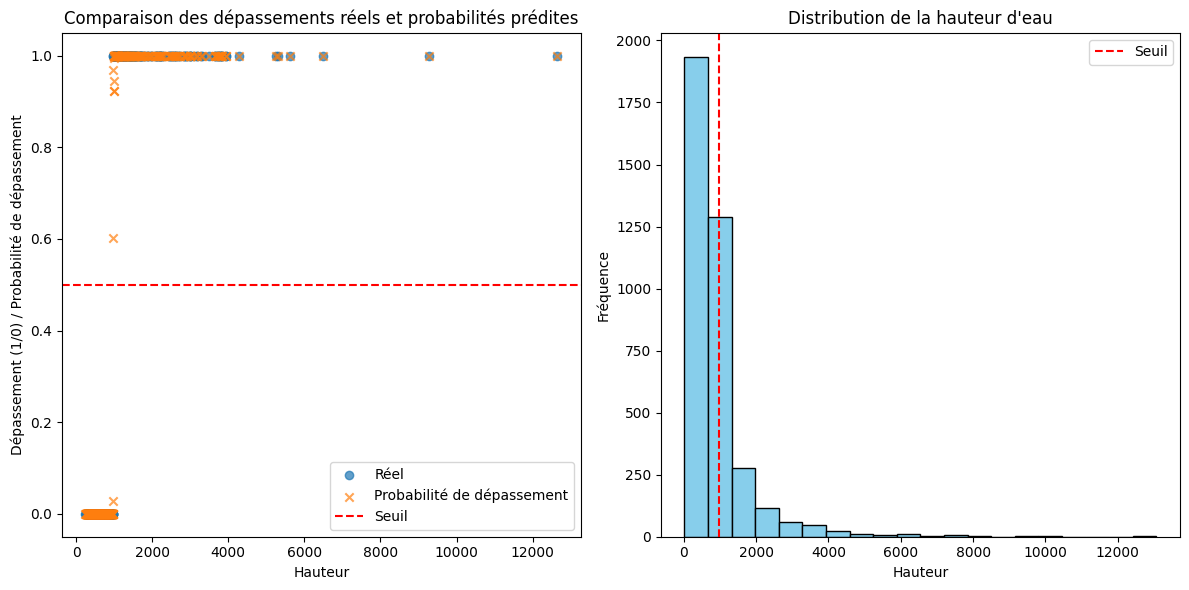

In [ ]:
proba_depassement = model.predict_proba(X_test)[:, 1]

# Visualisation des résultats
resultats = pd.DataFrame({
    'Hauteur réelle': X_test['resultat_obs_elab'],
    'Année': X_test['Annee_hauteur'],
    'Dépassement réel': y_test,
    'Probabilité de dépassement': proba_depassement
})

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(resultats['Hauteur réelle'], resultats['Dépassement réel'], label='Réel', alpha=0.7)
plt.scatter(resultats['Hauteur réelle'], proba_depassement, label='Probabilité de dépassement', marker='x', alpha=0.7)
plt.axhline(0.5, color='red', linestyle='--', label='Seuil')
plt.title('Comparaison des dépassements réels et probabilités prédites')
plt.xlabel('Hauteur')
plt.ylabel('Dépassement (1/0) / Probabilité de dépassement')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(station1['resultat_obs_elab'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(seuil1, color='red', linestyle='--', label='Seuil')
plt.title('Distribution de la hauteur d\'eau')
plt.xlabel('Hauteur')
plt.ylabel('Fréquence')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
resultats

,Hauteur réelle,Année,Dépassement réel,Probabilité de dépassement
1580,2180.0,2009,1,1.000000e+00
2257,2997.0,2012,1,1.000000e+00
263,749.0,2006,0,1.896642e-67
1837,1540.0,2010,1,1.000000e+00
3653,962.0,2016,0,8.976065e-07
...,...,...,...,...
3527,2248.0,2016,1,1.000000e+00
734,526.0,2007,0,1.331443e-132
505,936.0,2006,0,6.228689e-13
1641,472.0,2010,0,9.021441e-149


In [ ]:
resultats.groupby(["Année"])['Probabilité de dépassement'].mean()

Année
2005    0.193377
2006    0.312114
2007    0.078125
2008    0.144927
2009    0.271429
2010    0.256762
2011    0.487207
2012    0.187374
2013    0.442857
2014    0.333333
2015    0.100000
2016    0.425340
Name: Probabilité de dépassement, dtype: float64

In [ ]:
resultats.groupby(["Année"])['Dépassement réel'].sum()

Année
2005    12
2006    25
2007     5
2008    10
2009    19
2010    19
2011    24
2012     6
2013    31
2014    23
2015     6
2016    26
Name: Dépassement réel, dtype: int64

In [ ]:
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f'Précision du modèle: {accuracy}')
print(f'Matrice de confusion:\n{conf_matrix}')

Précision du modèle: 1.0
Matrice de confusion:
[[552   0]
 [  0 206]]


In [ ]:
station1.head(1)

,code_site,code_station,date_obs_elab,resultat_obs_elab,grandeur_hydro_elab,longitude_station,latitude_station,altitude_ref_alti_station,libelle_site,libelle_station,code_cours_eau,libelle_cours_eau,longitude_site,altitude_site,Annee_hauteur,depasse,Mois_hauteur,Jour_hauteur
0,10150001,1015000101,2005-02-22,2106.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,-61.6932,214.38,2005,1,2,22


Analyse En fonction date

Modèle Poisson

In [ ]:
fig = px.histogram(station1, x="resultat_obs_elab")
fig.show()

In [ ]:
station1['resultat_obs_elab']

0       2106.0
1        973.0
2       2758.0
3       2818.0
4       2521.0
         ...  
3784     628.0
3785    1397.0
3786     906.0
3787    1101.0
3788    7688.0
Name: resultat_obs_elab, Length: 3789, dtype: float64

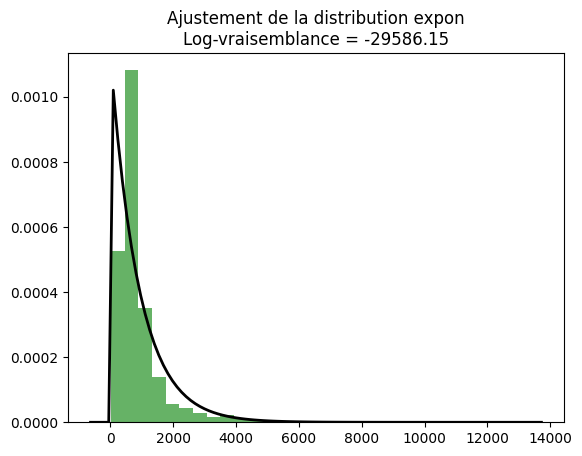

AttributeError: ignored

In [ ]:
data = station1['resultat_obs_elab']

distributions = [expon,gamma, norm]

# Boucle pour ajuster et afficher chaque distribution
for distribution in distributions:
    # Ajuster la distribution
    if distribution == norm:
        loc, scale = distribution.fit(data)
        params = {'loc': loc, 'scale': scale}
    else:
        params = distribution.fit(data)

    # Calculer la log-vraisemblance
    if distribution == gamma:
        log_likelihood = distribution.logpmf(data, *params).sum()
    elif distribution == norm:
        log_likelihood = distribution.logpdf(data, **params).sum()
    else:
        log_likelihood = distribution.logpdf(data, *params).sum()

    # Créer un histogramme des données
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

    # Créer la distribution ajustée
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    if distribution == norm:
        p = distribution.pdf(x, **params)
    else:
        p = distribution.pdf(x, *params)
    plt.plot(x, p, 'k', linewidth=2)

    # Afficher le résultat
    title = f"Ajustement de la distribution {distribution.name}\nLog-vraisemblance = {log_likelihood:.2f}"
    plt.title(title)
    plt.show()

In [ ]:
#pip install streamlit

In [ ]:
data.index[:3789]

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788],
      dtype='object', length=3789)

# Analyse des données météo

In [ ]:
donne_meteo.head(1)

,Annee,Mois,Station,Altitude (m),Coordonnées,Jour,Temp_Min (°C),Temp_Max (°C),Precipitation (mm),Rafale max (km/h),Neige (cm)
0,2020,janvier,Abbeville,70,"50,13°N | 1,84°E",Mercredi 1,-0.9,3.3,0.0,26.3,NaN


In [ ]:
donne_meteo['Precipitation (mm)'] = donne_meteo['Precipitation (mm)'].str.replace('h','', regex=True)
donne_meteo['Precipitation (mm)'] = donne_meteo['Precipitation (mm)'].str.replace('mn','', regex=True)
donne_meteo['Precipitation (mm)'] = donne_meteo['Precipitation (mm)'].str.replace(' ','', regex=True)


AttributeError: ignored

In [ ]:
donne_meteo['Temp_Min (°C)'] = donne_meteo['Temp_Min (°C)'].str.replace('°C','', regex=True)
donne_meteo['Temp_Min (°C)'] = donne_meteo['Temp_Min (°C)'].str.replace(' ','', regex=True)
donne_meteo.dropna(subset=['Temp_Min (°C)'], inplace=True)

In [ ]:
donne_meteo['Temp_Max (°C)'] = donne_meteo['Temp_Max (°C)'].str.replace('°C','', regex=True)
donne_meteo['Temp_Max (°C)'] = donne_meteo['Temp_Max (°C)'].str.replace(' ','', regex=True)
donne_meteo.dropna(subset=['Temp_Max (°C)'], inplace=True)

In [ ]:
donne_meteo['Rafale max (km/h)'] = donne_meteo['Rafale max (km/h)'].str.replace(' W/m²','', regex=True)

In [ ]:
donne_meteo['Precipitation (mm)'] = donne_meteo['Precipitation (mm)'].astype(float)
donne_meteo['Temp_Min (°C)'] = pd.to_numeric(donne_meteo['Temp_Min (°C)'], errors='coerce')
donne_meteo['Temp_Max (°C)'] = pd.to_numeric(donne_meteo['Temp_Max (°C)'], errors='coerce')
donne_meteo['Rafale max (km/h)'] = donne_meteo['Rafale max (km/h)'].astype(float)

In [ ]:
donne_meteo["Station"].unique()

array(['Abbeville', 'Abriès-Ristolas - nivose', 'Agen - La Garenne',
       'Aix Les Milles', "Ajaccio - Campo dell'Oro",
       'Ajaccio - La Parata', 'Albi-Le Séquestre', 'ALBI/LE SEQUESTRE &',
       'Alençon - Valframbert', 'Alenya - Mas Blanc', 'ALERIA RADAR',
       'Ambérieu', 'Amiens-Glisy', 'Angers - Marcé', 'Angers-Beaucouzé',
       'Angoulême - Brie-Champnier', 'Annecy-Meythet', 'ANNECY-MEYTHET',
       'Anse Bertrand Hippodrome (Guadeloupe)',
       "Anse d'Arlet (Martinique)", 'Antibes - La Garoupe', 'ANTIFER',
       'Apt St. Christol', 'ARCIS SUR AUBE', 'Arêches - Nivose',
       'Arette La Pierre-Saint-Martin - nivose', 'Artouste - nivose',
       'Asco-Stagnu - nivose', 'Ascou Pailheres - nivose', 'Atuona',
       'Aubenas-Vals (Lanas)', 'AUCH-IN-ARMAGNAC', 'Auch-Lamothe',
       'Audinghen - Cap Gris-Nez', 'Aurillac', 'AURILLAC CITY',
       'Auris en Oisans - Nivose', 'Auron - nivose', 'Auxerre',
       'Auxerre-Perrigny', 'Auzeville-Tolosane - Borde-Rouge',
       

## Analyse Exemple Données Abbeville

In [ ]:
donne_meteo_abeville = donne_meteo[donne_meteo["Station"]=="Abbeville"]

In [ ]:
donne_meteo_abeville.columns

Index(['Annee', 'Mois', 'Station', 'Altitude (m)', 'Coordonnées', 'Jour',
       'Temp_Min (°C)', 'Temp_Max (°C)', 'Precipitation (mm)',
       'Rafale max (km/h)', 'Neige (cm)'],
      dtype='object')

In [ ]:
a=donne_meteo_abeville.groupby(["Annee","Mois"]).mean()['Precipitation (mm)']

<Axes: xlabel='Annee,Mois'>

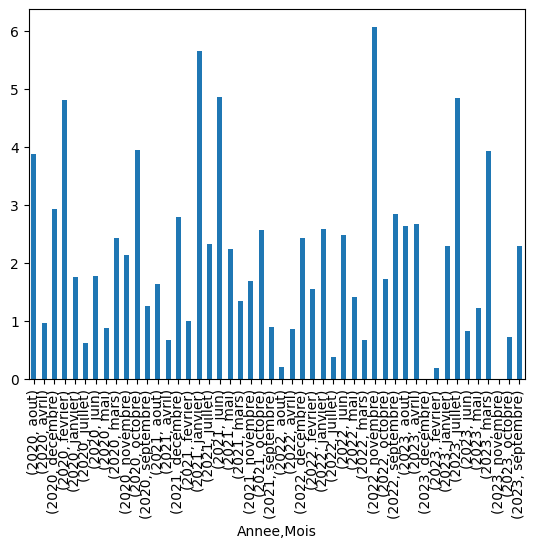

In [ ]:
a.plot(kind='bar')

<Axes: xlabel='Mois'>

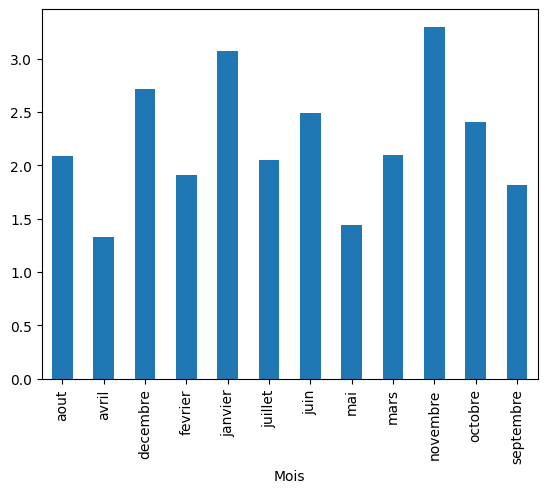

In [ ]:
a=donne_meteo_abeville.groupby(["Mois"]).mean()['Precipitation (mm)']
a.plot(kind='bar')

In [ ]:
corr_matrix = donne_meteo.corr()

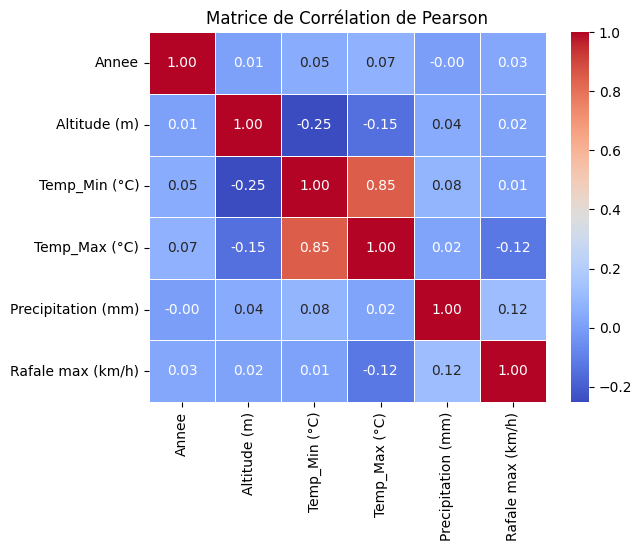

In [ ]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title("Matrice de Corrélation de Pearson")
plt.show()